<a href="https://colab.research.google.com/github/OlyKoek/Udemy-AIperfectMaster-colabo/blob/main/Section13/make_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# モデルの訓練と保存
Google Colaboratoryで画像識別用のモデルを構築し、訓練します。  
今回は、cifar-10を訓練データに使います。  
訓練済みのモデルは保存し、ダウンロードします。

## バージョンの確認
念のために、以下のコードによりtensorflowとKerasのバージョンを確認しておきましょう。

In [2]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2.19.0
3.10.0


## 使用ライブラリ

In [37]:
# 必要ライブラリ
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import cifar10 # 10 category dataset
from keras.models import Sequential
from keras import Input
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomZoom, Rescaling, BatchNormalization
from keras.optimizers import Adam

from keras.models import Model
from keras.callbacks import LambdaCallback

## 訓練データの読み込み
前のImageDataGeneratorが廃止になっていたので、tensorflow.keras.preprocessing.image import ImageDataGeneratorに変更。


x_train.shape: (50000, 32, 32, 3)
x_train.dtype: uint8
x_train range 0.0 -> 255.0
dtype: uint8


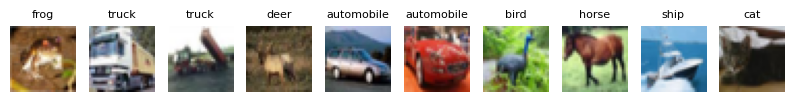

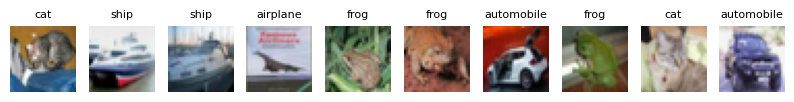

In [49]:
# データ読み込み
(x_train, t_train), (x_test, t_test) = cifar10.load_data()

# データの可視化 cifar10
classes = ['airplane','automobile','bird','cat','deer', 'dog','frog','horse','ship','truck']

# データの確認
print("x_train.shape:", x_train.shape)
print("x_train.dtype:", x_train.dtype)
print("x_train range", float(x_train.min()), "->", float(x_train.max()))
print("dtype:", x_train.dtype)

plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(x_train[i])
    plt.axis("off")
    plt.title(classes[t_train[i,0]], fontsize=8)
plt.show()

plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(x_test[i])
    plt.axis("off")
    plt.title(classes[t_test[i,0]], fontsize=8)
plt.show()

In [50]:
# 最初に使っていたけどRandom系のkeras便利ライブラリに切り替えて、モデルの内部でaugにお任せ

# # 前処理（float32にキャストして正規化して学習の安定化を図る）
# x_train_norm = x_train.astype("float32") / 255.0
# x_test_norm  = x_test.astype("float32") / 255.0

# # データの確認
# print("x_train.shape:", x_train_norm.shape)
# print("x_train.dtype:", x_train_norm.dtype)
# print("x_train range", float(x_train_norm.min()), "->", float(x_train_norm.max()))
# print("dtype:", x_train_norm.dtype)

t_train to onehot shape: (50000, 1) -> (50000, 10)
t_train to onehot dtype: uint8 -> float64
t_train onehot range 0.0 -> 1.0


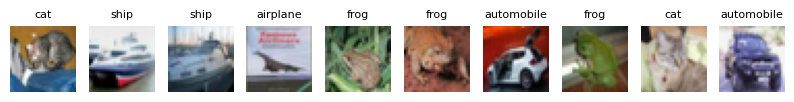

In [51]:
# one-hot convert
n_class = 10
t_train_onehot = keras.utils.to_categorical(t_train, n_class)
t_test_onehot  = keras.utils.to_categorical(t_test, n_class)

# one-hot後のデータの確認
print("t_train to onehot shape:", t_train.shape, "->", t_train_onehot.shape)
print("t_train to onehot dtype:", t_train.dtype, "->", t_train_onehot.dtype)
print("t_train onehot range", float(t_train_onehot.min()), "->", float(t_train_onehot.max()))

plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(x_test[i])
    plt.axis("off")
    cls_id = int(t_test_onehot[i].argmax())
    plt.title(classes[cls_id], fontsize=8)
plt.show()

## モデルの構築
CNNのモデルを構築します。

In [52]:
aug = Sequential([
    Rescaling(1./255), # 画像を0-1に正規化 floatにして数値的にパラメータ分解能を上げる
    RandomFlip("horizontal"), # 一定確率で左右反転
    RandomRotation(0.1), # 10%程度回転させる
    RandomZoom(0.1), # 10%程度拡大縮小
])


model = Sequential([
    # TensroFlowの入力引数に画像情報を設定(heig:32,width:32,channel:3)
    # batchサイズは自動とのこと。
    Input(shape=x_train.shape[1:]),
    aug,

    # 畳込層の設定。
    # (3,3)ピクセル単位で周辺情報を抽出
    # same:出力のサイズを入力と同じに保つ
    Conv2D(32, (3, 3), padding="same"), BatchNormalization(), Activation("relu"),
    Conv2D(32, (3, 3), padding="same"), BatchNormalization(), Activation("relu"),

    # Poolic層
    # 特徴を圧縮して、重要情報だけを抽出する
    # 2*2の範囲で最大値を取る＝画像サイズが30->15のように圧縮される。
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), padding="same"), BatchNormalization(), Activation("relu"),
    Conv2D(64, (3, 3), padding="same"), BatchNormalization(), Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256), Activation("relu"),
    Dropout(0.5),
    Dense(n_class), Activation("softmax"),
])

model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_19 (Sequential)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_60 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_61 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_62 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_63 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_64 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │         2,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_65 (Activation)      │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,117,738 (4.26 MB)

 Trainable params: 1,117,354 (4.26 MB)

 Non-trainable params: 384 (1.50 KB)

### (次の学習で可視化に使用する作業用の関数)

In [53]:
def show_feature_maps(epoch, logs):
    if epoch % 10 == 0 or epoch == 0:  # 5エポックごとに表示
        test_img = x_test[:1]                         # idx=0 固定
        activations = activation_model.predict(test_img, verbose=0)
        first_layer_act = activations[0][0]                # Conv1 の特徴マップ (H, W, C)

        label_id = int(t_test_onehot[0].argmax())          # idx=0 の正解ラベル

        n_show = 4 # 確認用に表示する特徴フィルタの数
        fig, axes = plt.subplots(1, n_show+1, figsize=(8, 2), constrained_layout=True)

        # 比較用に元画像を一番左に追加
        axes[0].imshow(x_test[0])
        axes[0].axis('off')
        axes[0].set_title(f"{classes[label_id]}", fontsize=8)

        for i in range(n_show):
            axes[i+1].imshow(first_layer_act[:, :, i], cmap='viridis') # 0-i番目までのフィルタ特徴画像の出力
            axes[i+1].axis('off')
            axes[i+1].set_title(f"ch {i}", fontsize=8)

        fig.suptitle(f"Epoch {epoch} | idx=0 | label={classes[label_id]}")
        plt.show()

## 学習
モデルを訓練します。  
ImageDataGeneratorを使用する際は、学習にfit_generatorメソッドを使います。  
学習には時間がかかりますので、編集→ノートブックの設定のハードウェアアクセラレーターでGPUを選択しましょう。

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2769 - loss: 2.0196

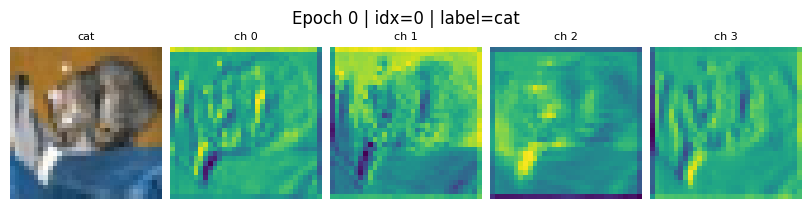

782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.2770 - loss: 2.0194 - val_accuracy: 0.4168 - val_loss: 1.5964
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.4031 - loss: 1.6054 - val_accuracy: 0.4717 - val_loss: 1.4886
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.4591 - loss: 1.4731 - val_accuracy: 0.5561 - val_loss: 1.2771
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.4832 - loss: 1.4041 - val_accuracy: 0.5925 - val_loss: 1.1516
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5112 - loss: 1.3442 - val_accuracy: 0.5830 - val_loss: 1.2472
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5346 - loss: 1.2894 - val_accuracy: 0.6638 - val_loss: 0.9891
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5529 - loss: 1.2486 - val_accuracy: 0.6706 - val_loss: 0.9671
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5671 - loss: 1.1988 - val_accurac

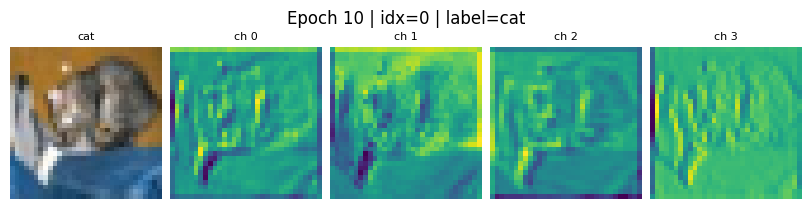

782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.6058 - loss: 1.1087 - val_accuracy: 0.6643 - val_loss: 1.0281
Epoch 12/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.6132 - loss: 1.0844 - val_accuracy: 0.6654 - val_loss: 0.9491
Epoch 13/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.6203 - loss: 1.0810 - val_accuracy: 0.6538 - val_loss: 1.0364
Epoch 14/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.6280 - loss: 1.0621 - val_accuracy: 0.6988 - val_loss: 0.8778
Epoch 15/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.6368 - loss: 1.0331 - val_accuracy: 0.6636 - val_loss: 1.0047
Epoch 16/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.6448 - loss: 1.0104 - val_accuracy: 0.6716 - val_loss: 0.9614
Epoch 17/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.6582 - loss: 0.9768 - val_accuracy: 0.6959 - val_loss: 0.8959
Epoch 18/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.6596 - loss: 0.9768 - val_

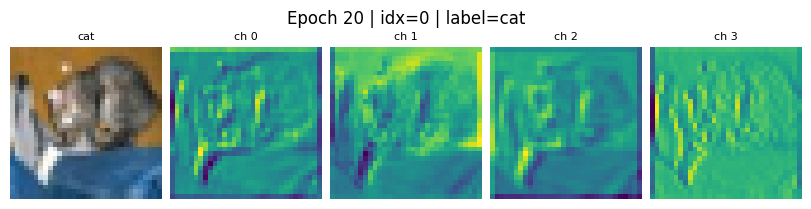

782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.6839 - loss: 0.9189 - val_accuracy: 0.7103 - val_loss: 0.8895
Epoch 22/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.6914 - loss: 0.9042 - val_accuracy: 0.7308 - val_loss: 0.8039
Epoch 23/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.6958 - loss: 0.8894 - val_accuracy: 0.7133 - val_loss: 0.8416
Epoch 24/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7008 - loss: 0.8729 - val_accuracy: 0.7403 - val_loss: 0.7815
Epoch 25/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7097 - loss: 0.8396 - val_accuracy: 0.7418 - val_loss: 0.7656
Epoch 26/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7142 - loss: 0.8383 - val_accuracy: 0.7421 - val_loss: 0.7743
Epoch 27/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7228 - loss: 0.8214 - val_accuracy: 0.7414 - val_loss: 0.7536
Epoch 28/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7288 - loss: 0.8049 - val_

In [54]:
# HP
batch_size = 64
epochs = 30

# === 学習の可視化設定 ===
# convの層の出力を取得
conv_layers = [l for l in model.layers if isinstance(l, Conv2D)]
conv_outputs = [l.output for l in conv_layers]
activation_model = Model(inputs=model.inputs, outputs=conv_outputs)

# Callbackを登録＆Fit関数に渡す
cb_feat = LambdaCallback(on_epoch_end=show_feature_maps)
# ====================

# === 学習 ===
history = model.fit(
    x_train, t_train_onehot,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, t_test_onehot),
    shuffle=True,
    callbacks=[cb_feat]
)

## 学習の推移
学習の推移を表示します。  

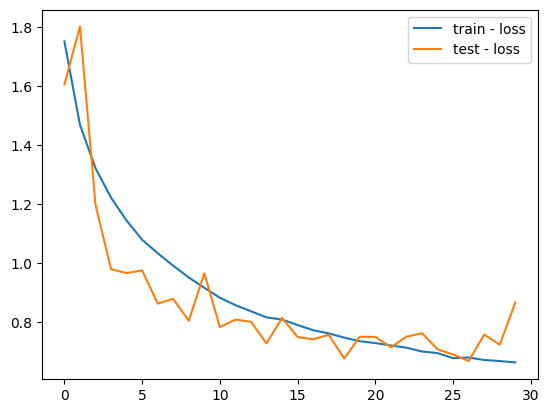

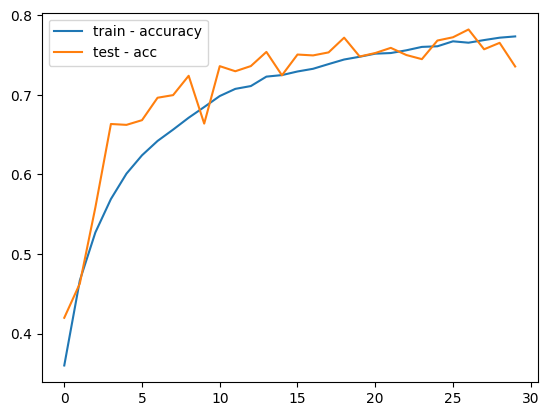

健全な学習状態


In [45]:
# 学習曲線
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

plt.plot(np.arange(len(train_loss)), train_loss, label="train - loss")
plt.plot(np.arange(len(val_loss)), val_loss, label="test - loss")
plt.legend(); plt.show()

plt.plot(np.arange(len(train_acc)), train_acc, label="train - accuracy")
plt.plot(np.arange(len(val_acc)), val_acc, label="test - acc")
plt.legend(); plt.show()

# 学習判断
train_acc = history.history["accuracy"][-1]
val_acc = history.history["val_accuracy"][-1]
gap = train_acc - val_acc

if gap > 0.1:
    print("過学習の可能性が高い")
elif gap < 0.05:
    print("健全な学習状態")
else:
    print("軽度の過学習かも？")

## 評価
モデルの評価を行います。  

In [47]:
# 評価
loss, accuracy = model.evaluate(x_test, t_test_onehot)
print("loss:", loss, "accuracy:", accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7385 - loss: 0.8531
loss: 0.8672019243240356 accuracy: 0.7357000112533569


## モデルの保存とダウンロード
他の環境でも使えるように、モデルを保存しダウンロードします。

In [12]:
from google.colab import files

# 保存とダウンロード（.h5 で保存したい場合は h5py が必要）
from google.colab import files
model.save("image_classifier.keras", include_optimizer=False)
files.download("image_classifier.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>